# Landscape Analysis

## Intro

In this section, we do some intro setup, loading packages and the data files we computed in "persistent_hom_landscape_computation.py".

### Requirement setup
In the next couple cells, we import all the package requirements for the rest of the notebook. Note that when we import mayavi, we need to redefine the base64 encodestring and decodestring to adjust some version incompatibility.

In [1]:
# Import general packages needed for analysis
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from PIL import Image
import pickle
import itertools
from collections import namedtuple
from sklearn.decomposition import PCA
from sklearn.svm import SVC
# gudhi is the package we will use for computing persistent homology and landscapes.
import gudhi
import gudhi.representations

In [2]:
# Set up color-coding based on class
l2c = {
    'Sugar': np.array([241, 244, 66])/255.,
    'Flower': np.array([244, 65, 65])/255.,
    'Fish': np.array([65, 241, 244])/255.,
    'Gravel': np.array([73, 244, 65])/255.
}
l2ic = {
    'Sugar': np.array([241, 244, 66]),
    'Flower': np.array([244, 65, 65]),
    'Fish': np.array([65, 241, 244]),
    'Gravel': np.array([73, 244, 65])
}

### Data structure setup

Here we import the data files that we obtained from the "persistent_hom_landscape_computation.py" script, and set up the tda_data namedtuple that was used in that script.

In [11]:
# Use this box to choose which regimes to compare - note that the ordering 
regimes = ['Sugar', 'Flower']

In [12]:
# Set up namedtuple used in compute_dists.py
tda_data = namedtuple('tda_data', ['H0', 'H1'])

In [42]:
# Set up the path to the image files - change to where you downloaded your data to.
IMGPATH = 'D:/research/crowdsourced_clouds/sugar-flower-fish-or-gravel/raw_data/'

In [13]:
# Import training data
train_fn_prefix = './processed_data/train_TDA'
# Load data files
full_train_annos = pd.read_pickle(train_fn_prefix + '_sample_df.pkl')
full_train_raw_lscapes = pd.read_pickle(train_fn_prefix + '_landscapes.pkl')
full_train_boxes = pd.read_pickle(train_fn_prefix + '_sample_boxes.pkl')
full_train_barcodes = pd.read_pickle(train_fn_prefix + '_raw_barcodes.pkl')
# Select only samples from the regimes chosen
train_selector = full_train_annos['tool_label'].isin(regimes)
train_annos = full_train_annos.loc[train_selector]
train_raw_lscapes = list(itertools.compress(full_train_raw_lscapes, train_selector))
train_boxes = list(itertools.compress(full_train_boxes, train_selector))
train_barcodes = list(itertools.compress(full_train_barcodes, train_selector))

In [14]:
# Import test data
test_fn_prefix = './processed_data/test_TDA'
# Load data files
full_test_annos = pd.read_pickle(test_fn_prefix + '_sample_df.pkl')
full_test_raw_lscapes = pd.read_pickle(test_fn_prefix + '_landscapes.pkl')
full_test_boxes = pd.read_pickle(test_fn_prefix + '_sample_boxes.pkl')
full_test_barcodes = pd.read_pickle(train_fn_prefix + '_raw_barcodes.pkl')
# Select only samples from the regimes chosen
test_selector = full_test_annos['tool_label'].isin(regimes)
test_annos = full_test_annos.loc[test_selector]
test_raw_lscapes = list(itertools.compress(full_test_raw_lscapes, test_selector))
test_boxes = list(itertools.compress(full_test_boxes, test_selector))
test_barcodes = list(itertools.compress(full_test_barcodes, test_selector))

In [15]:
# Reshape data to be more compatible with analysis techniques
train_lscapes = [np.concatenate([a.H0, a.H1]) for a in train_raw_lscapes]
test_lscapes = [np.concatenate([a.H0, a.H1]) for a in test_raw_lscapes]

In [48]:
# Read out sample size from the boxes file
sample_size = full_train_boxes[-1]

## Projection and separation
We next project the data down to 3 dimensions using PCA and compute the best separating plane using SVM.

In [16]:
# Embed the datapoints in 3d
PCA_embed = PCA(n_components=3)
embedded_3D = PCA_embed.fit_transform(train_lscapes)
test_embedded_3D = PCA_embed.transform(test_lscapes)

In [17]:
# Run SVM on the data, using pre-established classes
svm_PCA = SVC(kernel='linear')
svm_PCA.fit(X = embedded_3D, y = train_annos['tool_label'])

SVC(kernel='linear')

In [18]:
# Give SVM score for training and test data
print('Training score: ' + str(svm_PCA.score(embedded_3D, train_annos['tool_label'])))
print('Test score: ' + str(svm_PCA.score(test_embedded_3D, test_annos['tool_label'])))

Training score: 0.8725
Test score: 0.825


## Visualization

#### Graphical set up
In this subsection, we set up all the prerequisites needed to actually create the 3D and 2D graphs.

In [19]:
# Make a grid
def make_meshgrid(x, y, h=1):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [20]:
# Make a grid of points lying on the separating plane found from SVM
w = svm_PCA.coef_[0]
b = svm_PCA.intercept_[0]
xx, yy = make_meshgrid(test_embedded_3D[:, 0], test_embedded_3D[:, 1], 200)
Z = -w[0]/w[2] * xx - w[1]/w[2] * yy - b/w[2]
print(w)

[-0.000855   -0.00581779 -0.00941351]


In [21]:
# Define a custom colormap
sffg_colors = np.zeros((256, 4))
for i in range(0, 64):
    sffg_colors[i, :3] = l2ic['Sugar']
    sffg_colors[i + 64, :3] = l2ic['Fish']
    sffg_colors[i + 128, :3] = l2ic['Flower']
    sffg_colors[i + 192, :3] = l2ic['Gravel']
sffg_colors[:, 3] = 255*np.ones(256)

In [22]:
# Define colors for comparison
def l2b(a):
    if a == 'Sugar':
        return 0.125
    elif a == 'Fish':
        return 0.375
    elif a == 'Flower':
        return 0.625
    elif a == 'Gravel':
        return 0.875

### Mayavi 3D plotting (OPTIONAL, requires additional package dependencies)

In this subsection, we produce nice 3D visualizations using the [Mayavi package](https://docs.enthought.com/mayavi/mayavi/), which takes a bit of fiddling to get installed and working properly. No other portion of the notebook or algorithm relies on this, so it is entirely for producing prettier graphs.

#### Imports and setup

In [23]:
# Import Mayavi for 3D viewing of the data -- optional
import base64
base64.encodestring = base64.encodebytes
base64.decodestring = base64.decodebytes
from mayavi import mlab
from IPython.display import display
mlab.init_notebook('ipy')

Notebook initialized with ipy backend.


#### 3D Plot
Here, we set up and create the 3D plot of the visualization using MayaVI

In [25]:
mlab.clf()
# Set up frame
M = mlab.figure(size=(800, 500), bgcolor=(1.0, 1.0, 1.0))
# Create the point cloud with an arbitrary colormap
mp = mlab.points3d(test_embedded_3D[:, 0], test_embedded_3D[:, 1], test_embedded_3D[:, 2], [l2b(a) for a in test_annos['tool_label']], 
                   mode='sphere', scale_mode='none', scale_factor=50, colormap='Accent', vmin=0, vmax=1)
# Set the colormap to be the custom colormap defined above
mp.module_manager.scalar_lut_manager.lut.table = sffg_colors
# Create a wireframe visualization of the SVM separating plane
ms = mlab.mesh(xx, yy, Z, representation='wireframe', color=(0.2, 0.2, 0.2), opacity=0.2)

In [134]:
# Create a tube visualizing virtual landscapes
w_scaled = w/np.linalg.norm(w)
prods = np.dot(test_embedded_3D, w_scaled)
L_data = np.outer(w_scaled, np.linspace(prods.min(), prods.max(), 10)).transpose()
ml = mlab.plot3d(L_data[:, 0], L_data[:, 1], L_data[:, 2], color=(1, 0, 0), tube_radius=4)

In [133]:
M

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x01\xf4\x08\x02\x00\x00\x00J"\xde/\x00\…

### 2D Plot and Sample Visualizer
Here, we create Matplotlib 2D and 3D plots. The 2D plot is interactive, and clicking on a data point loads the corresponding full image and a zoomed-in view of the annotation.

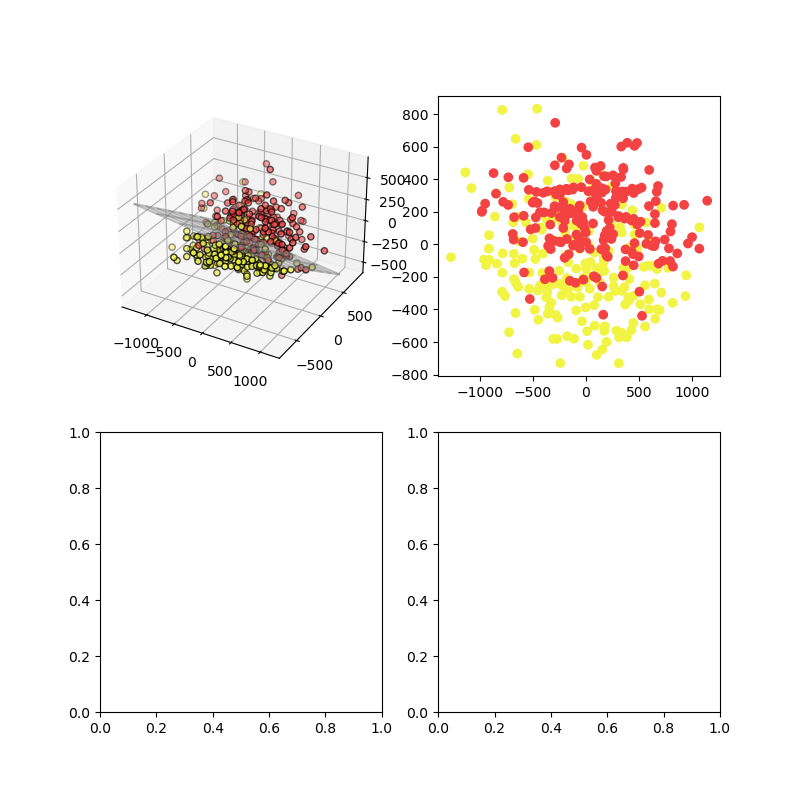

In [135]:
# Set up the plots
F, ax = plt.subplots(2, 2, figsize=(8, 8))
# Replace the top left subplot with a 3D plot
ax[0, 0].remove()
ax[0, 0] = F.add_subplot(2, 2, 1, projection='3d')
# Add the SVM hyperplane
ax[0, 0].plot_wireframe(xx, yy, Z, rcount = 10, ccount = 10, color='gray', alpha=0.5)
# Add a 3D scatter plot of the data embedded landscapes
scat_3D = ax[0, 0].scatter(test_embedded_3D[:, 0], test_embedded_3D[:, 1], test_embedded_3D[:, 2], c=[l2c[a] for a in test_annos['tool_label']], edgecolor='black')

# Also plot the data in 2D along only the first two principal components
scat_2D = ax[0, 1].scatter(test_embedded_3D[:, 0], test_embedded_3D[:, 1], c=[l2c[a] for a in test_annos['tool_label']], picker=5)

# Set up the interactivity in the 2D plot
def onclick(event):
    # Reset the example viewing subplots
    ax[1, 0].clear()
    ax[1, 1].clear()
    # Reset all point sizes to default
    sizes = 36*np.ones(len(test_annos['tool_label']))
    # Find the index of the sample clicked on
    sample = event.ind[0]
    # Pull the annotation information from the example clicked on
    box = test_annos.iloc[sample]
    fn = IMGPATH + box.fn
    sub_samples = test_boxes[sample]
    # Set the point sizes to enlarge the clicked on point
    sizes[event.ind[0]] = 100
    # Set the 2D point sizes
    scat_2D.set_sizes(sizes)
    # Set the 3D point sizes
    ax[0, 0].clear()
    ax[0, 0].plot_wireframe(xx, yy, Z, rcount = 10, ccount = 10, color='gray', alpha=0.5)
    scat_3D = ax[0, 0].scatter(test_embedded_3D[:, 0], test_embedded_3D[:, 1], test_embedded_3D[:, 2], c=[l2c[a] for a in test_annos['tool_label']], s=sizes*0.8, edgecolor='black')
    # Open the image and plot both the complete image and the cropped annotation
    with Image.open(fn).convert('L') as img:
        ax[1, 0].imshow(img, cmap='gray')
        img_sample = img.crop((box.x, box.y, box.x + box.width, box.y + box.height))
        ax[1, 1].imshow(img_sample, cmap='gray')
    # Add the subsample boxes to both the full and cropped images
    for i in range(len(sub_samples)):
        rect = patches.Rectangle((sub_samples[i][0], sub_samples[i][1]), sample_size, sample_size, facecolor='none', edgecolor='white', lw=1)
        ax[1, 0].add_patch(rect)
        rect = patches.Rectangle((sub_samples[i][0] - box.x, sub_samples[i][1] - box.y), sample_size, sample_size, facecolor='none', edgecolor='white', lw=1)
        ax[1, 1].add_patch(rect)
    # Add an outer border to the annotation in the full image
    rect = patches.Rectangle((box.x, box.y), box.width, box.height, facecolor='none', edgecolor=l2c[box.tool_label], lw=3)
    ax[1, 0].add_patch(rect)


cid = F.canvas.mpl_connect('pick_event', onclick)

## Virtual landscape plots
In this section, we find the line in $\mathbb{R}^{2000}$ that is perpendicular to the hyperplane corresponding to the SVM separating plane in $\mathbb{R}^{3}$ and which goes through the geometric center of the point cloud of landscapes in $\mathbb{R}^{2000}$. We then present plots at each extreme of that line, along with one at the middle.

In [28]:
# Recover the 3 x 2000 matrix W that does the PCA embedding, and compute the geometric center of the data cloud, vbar
W = PCA_embed.components_
vbar = np.mean(test_lscapes, 0)

In [29]:
# Record the defining normal vector and shift for the SVM separating hyperplane
w = svm_PCA.coef_[0]
b = svm_PCA.intercept_[0]

In [30]:
# Lift these to a corresponding normal vector and shift defining a hyperplane in R^2000
w_high = np.matmul(w, W)
b_high = -np.matmul(w_high, vbar) + b

In [31]:
# Normalize our high-dimensional terms
w_high = w_high / np.linalg.norm(w_high)
b_high = b_high / np.linalg.norm(w_high)

In [63]:
# Test how far from and on which side of the high-dimensional separating hyperplane each point falls on, using the normal vector and shift
prods = np.dot(test_lscapes, w_high) + b_high

In [33]:
# Create a function that will display a landscape from vectorized data
def lscape_plotter(lscape, ax=None):
    # Define our x-axis as being between 0 and 255
    xsteps = np.linspace(0, 255, 200)
    # If we're not plotting into an existing figure, set up a new figure
    if not ax:
        F = plt.figure()
        ax = plt.gca()
    # Plot the 5 H0 landscape functions
    for i in range(5):
        ax.plot(xsteps, lscape[0 + i*200:200 + i*200], color='red')
    # Plot the 5 H1 landscape functions
    for i in range(5):
        ax.plot(xsteps, lscape[1000 + i*200:1200 + i*200], color='blue')
    # Set the ticks to be in reversed order, to correspond to our superlevelset formulation
    ax.set_xticks([0, 63, 127, 191, 255])
    ax.set_xticklabels([255, 191, 127, 127, 0])

Type: Flower


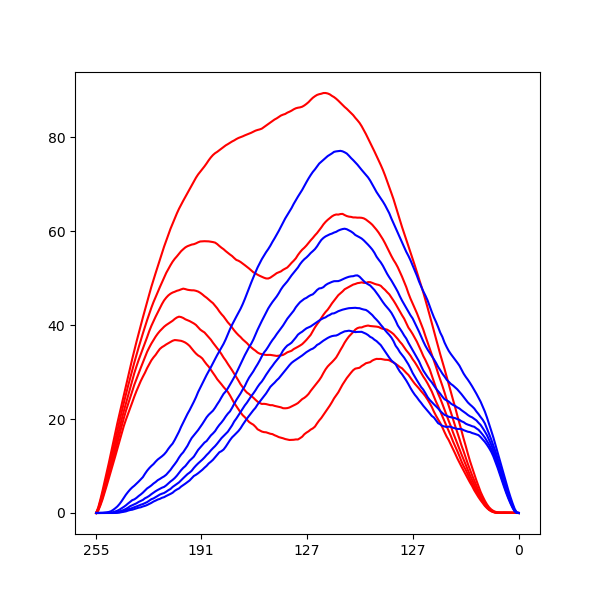

In [58]:
# Generate the minimum virtual landscape and plot it
min_lscape = vbar + prods.min()*w_high
F = plt.figure(figsize=(6, 6))
ax = plt.gca()
lscape_plotter(min_lscape, ax=ax)
print('Type: ' + test_annos.iloc[np.argmin(prods)].tool_label)

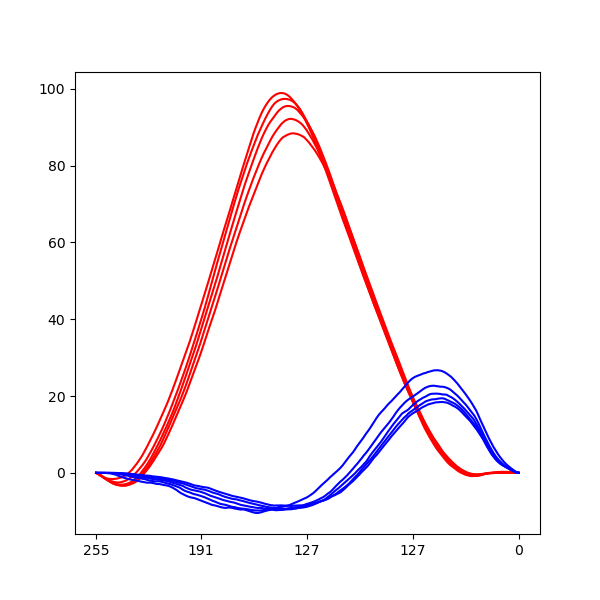

In [101]:
# Generate and plot the maximum virtual landscape
max_lscape = vbar + prods.max()*w_high
F = plt.figure(figsize=(6, 6))
ax = plt.gca()
lscape_plotter(max_lscape, ax=ax)
print('Type: ' + test_annos.iloc[np.argmax(prods)].tool_label)

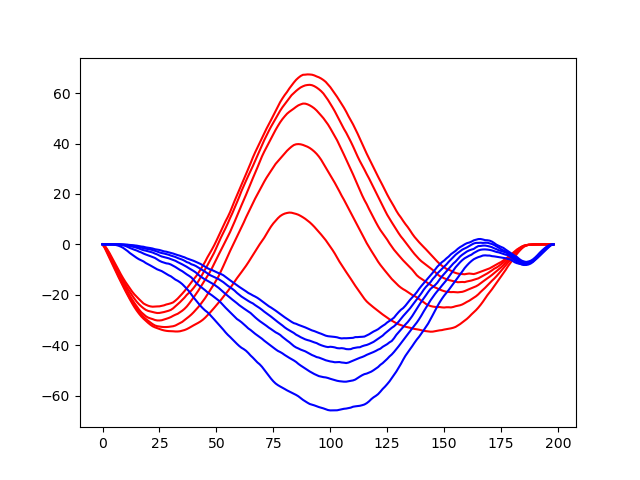

In [21]:
# Difference vector going from one side to the other
lscape_plotter(max_lscape - min_lscape)

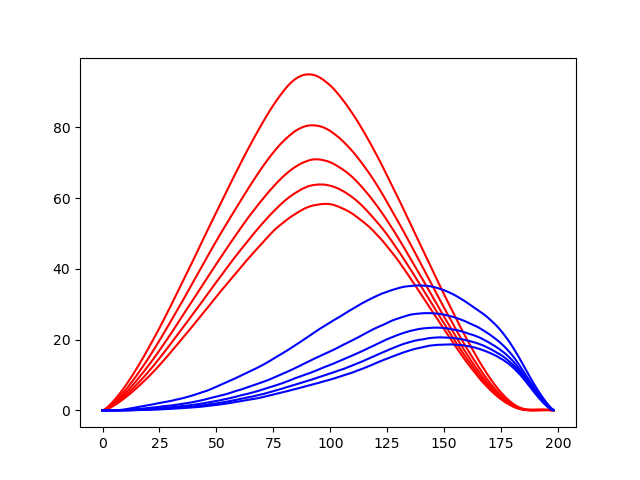

In [22]:
# Gives a point on the separating hyperplane lying on the line going through the center of the data
hyperplane_lscape = vbar - b_high*w_high
lscape_plotter(hyperplane_lscape)

## Extreme examples
In this section, we extract the actual landscapes and images for the most extreme examples farthest from the separating hyperplane on either side.

In [ ]:
# Create a function that will display a landscape from vectorized data
def lscape_plotter(lscape, ax=None):
    # Define our x-axis as being between 0 and 255
    xsteps = np.linspace(0, 255, 200)
    # If we're not plotting into an existing figure, set up a new figure
    if not ax:
        F = plt.figure()
        ax = plt.gca()
    # Plot the 5 H0 landscape functions
    for i in range(5):
        ax.plot(xsteps, lscape[0 + i*200:200 + i*200], color='red')
    # Plot the 5 H1 landscape functions
    for i in range(5):
        ax.plot(xsteps, lscape[1000 + i*200:1200 + i*200], color='blue')
    # Set the ticks to be in reversed order, to correspond to our superlevelset formulation
    ax.set_xticks([0, 63, 127, 191, 255])
    ax.set_xticklabels([255, 191, 127, 127, 0])

Flower


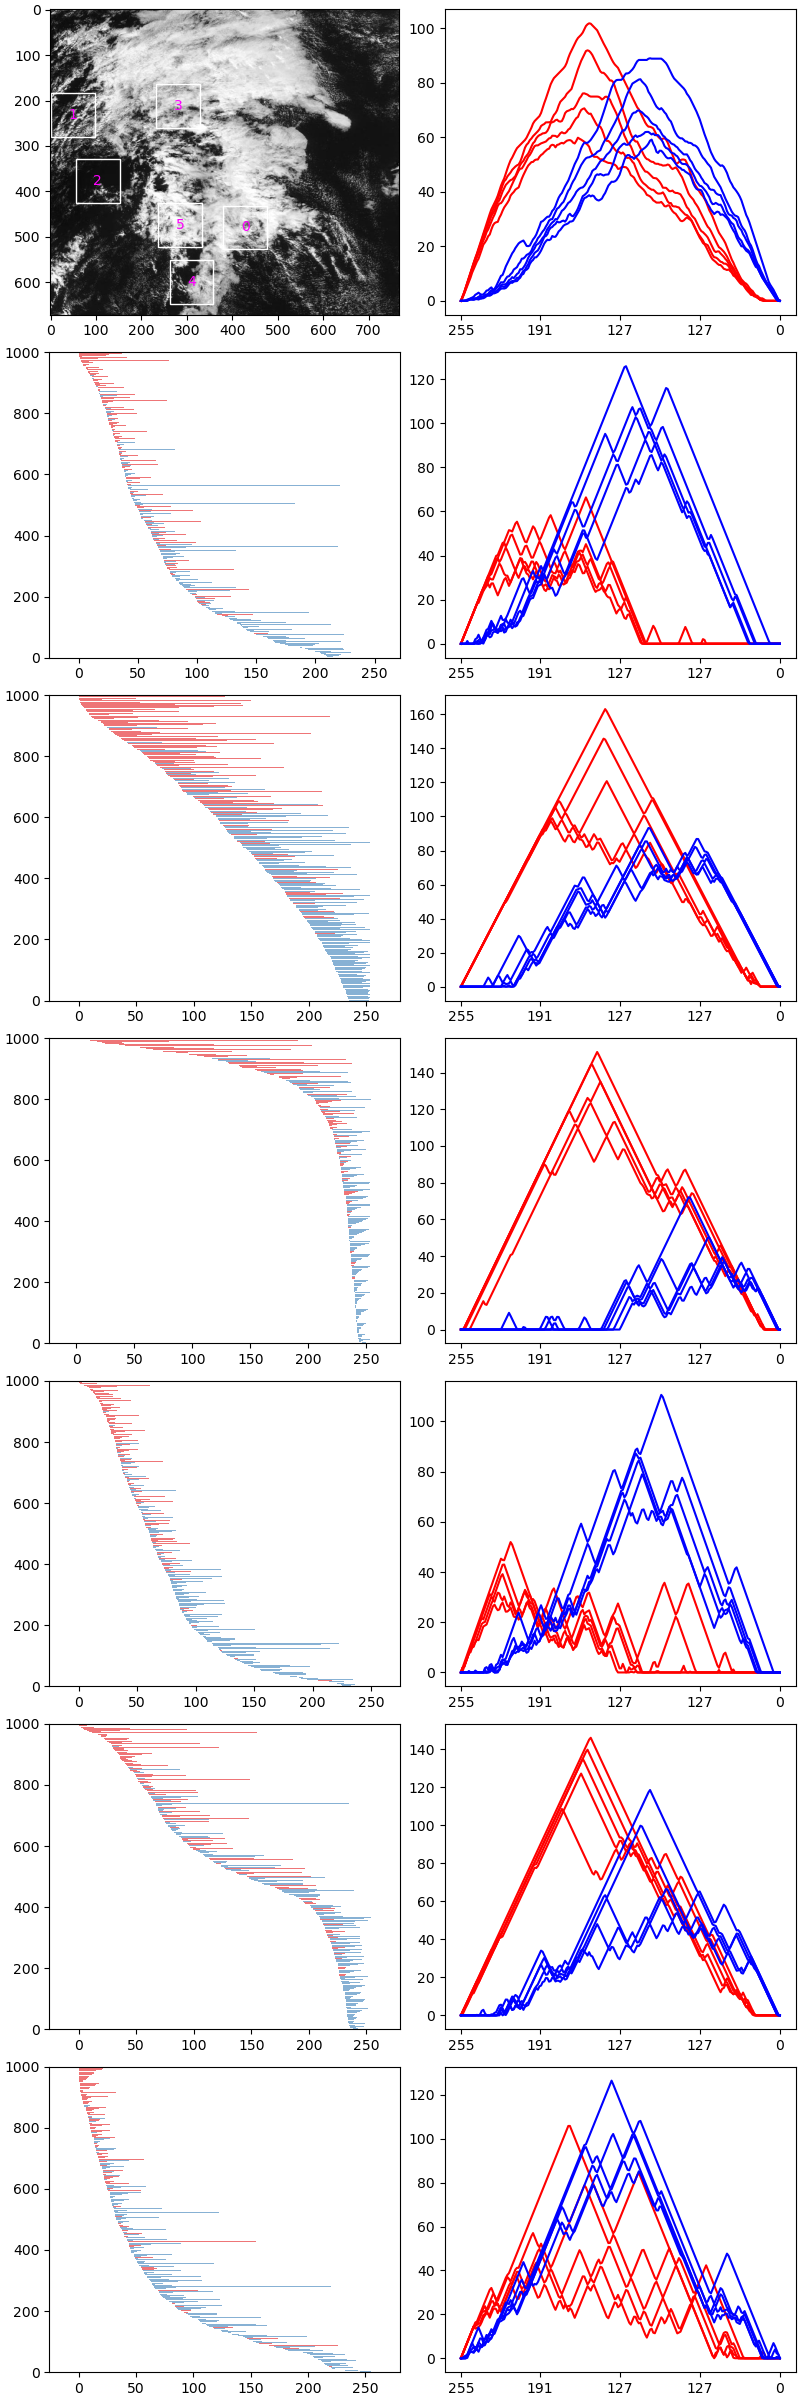

In [127]:
# Minimum extreme example
# Find the example farthest on the negative side of the hyperplane
index = np.argmin(prods)
lscape = test_lscapes[index]
coords = test_boxes[index]
box = test_annos.iloc[index]
fn = IMGPATH + box.fn
# Print the type of annotation
print(box.tool_label)

# Set up the figure
F, ax = plt.subplots(7, 2, figsize=(8, 24), constrained_layout=True)
# Plot the overall landscape
lscape_plotter(lscape, ax[0, 1])

# Open the image in grayscale and display it
with Image.open(fn).convert('L') as img:
    ax[0, 0].imshow(img.crop((box.x, box.y, box.x + box.width, box.y + box.height)), cmap='gray')
    # Loop over the subsamples
    for i in range(len(coords)):
        # Display the subsample box
        rect = patches.Rectangle((coords[i][0] - box.x, coords[i][1] - box.y), sample_size, sample_size, facecolor='none', edgecolor='white', lw=1)
        ax[0, 0].add_patch(rect)
        ax[0, 0].text(coords[i][0] - box.x + sample_size/2, coords[i][1] - box.y + sample_size/2, i, ha='center', va='center', c='magenta')
        
        # Pull the sample as a numpy array and compute its sublevelset persistent homology
        img_sample = np.array(img.crop((coords[i][0], coords[i][1], coords[i][0] + sample_size, coords[i][1] + sample_size)))
        cmplx = gudhi.CubicalComplex(top_dimensional_cells=255-img_sample[:, :])
        bc = cmplx.persistence(homology_coeff_field=2)
        # Plot the persistence barcode for this subsample
        gudhi.plot_persistence_barcode(bc, axes=ax[i+1, 0])
        ax[i+1, 0].set_xlabel('')
        ax[i+1, 0].set_ylabel('')
        ax[i+1, 0].set_title('')
        
        # Compute and plot the persistence landscape for this subsample
        lscape_comp = gudhi.representations.Landscape(resolution=200, sample_range=(0, 255))
        sample_lscape = np.concatenate(lscape_comp.transform((cmplx.persistence_intervals_in_dimension(0), cmplx.persistence_intervals_in_dimension(1))))
        lscape_plotter(sample_lscape, ax[i+1, 1])

Sugar


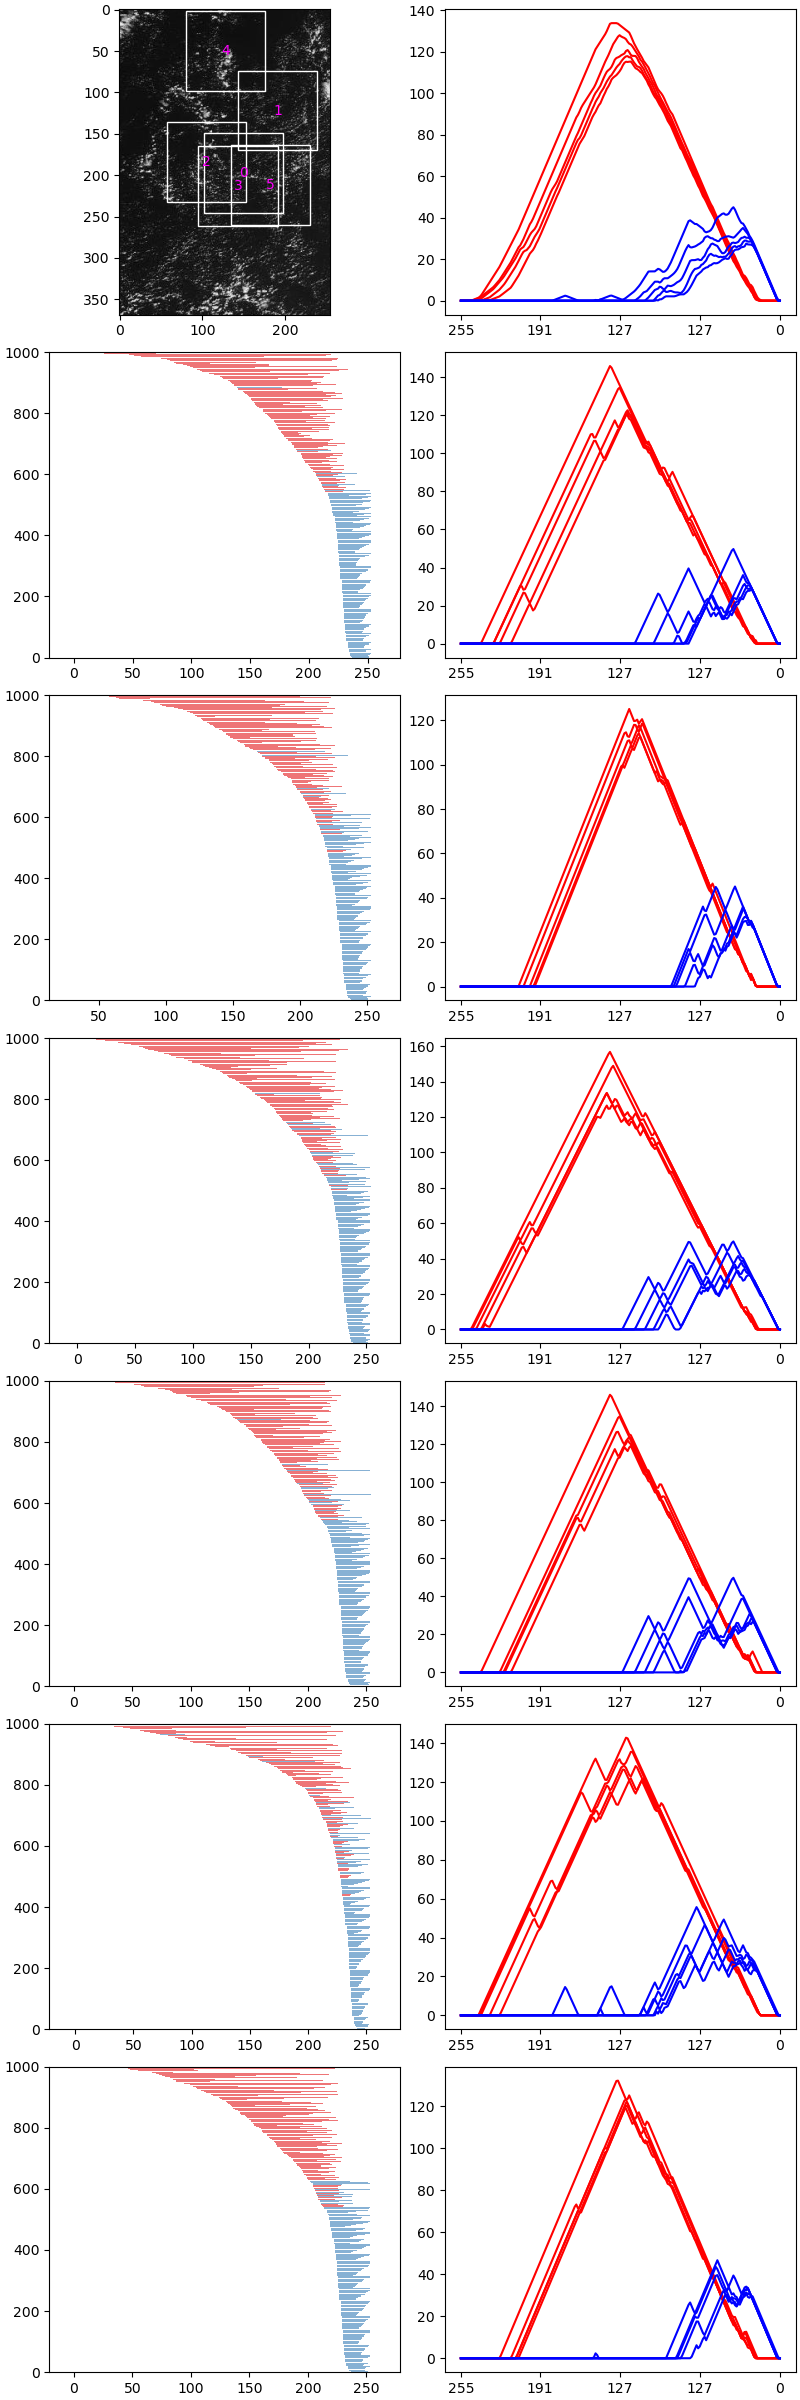

In [128]:
# Maximum extreme example
# Find the example farthest on the positive side of the hyperplane
index = np.argmax(prods)
lscape = test_lscapes[index]
coords = test_boxes[index]
box = test_annos.iloc[index]
fn = IMGPATH + box.fn
# Print the type of annotation
print(box.tool_label)

# Set up the figure
F, ax = plt.subplots(7, 2, figsize=(8, 24), constrained_layout=True)
# Plot the overall landscape
lscape_plotter(lscape, ax[0, 1])

# Open the image in grayscale and display it
with Image.open(fn).convert('L') as img:
    ax[0, 0].imshow(img.crop((box.x, box.y, box.x + box.width, box.y + box.height)), cmap='gray')
    # Loop over the subsamples
    for i in range(len(coords)):
        # Display the subsample box
        rect = patches.Rectangle((coords[i][0] - box.x, coords[i][1] - box.y), sample_size, sample_size, facecolor='none', edgecolor='white', lw=1)
        ax[0, 0].add_patch(rect)
        ax[0, 0].text(coords[i][0] - box.x + sample_size/2, coords[i][1] - box.y + sample_size/2, i, ha='center', va='center', c='magenta')
        
        # Pull the sample as a numpy array and compute its sublevelset persistent homology
        img_sample = np.array(img.crop((coords[i][0], coords[i][1], coords[i][0] + sample_size, coords[i][1] + sample_size)))
        cmplx = gudhi.CubicalComplex(top_dimensional_cells=255-img_sample[:, :])
        bc = cmplx.persistence(homology_coeff_field=2)
        # Plot the persistence barcode for this subsample
        gudhi.plot_persistence_barcode(bc, axes=ax[i+1, 0])
        ax[i+1, 0].set_xlabel('')
        ax[i+1, 0].set_ylabel('')
        ax[i+1, 0].set_title('')
        
        # Compute and plot the persistence landscape for this subsample
        lscape_comp = gudhi.representations.Landscape(resolution=200, sample_range=(0, 255))
        sample_lscape = np.concatenate(lscape_comp.transform((cmplx.persistence_intervals_in_dimension(0), cmplx.persistence_intervals_in_dimension(1))))
        lscape_plotter(sample_lscape, ax[i+1, 1])

## Random example finder
This code finds a random example and plots its average landscape, as well as the individual landscapes from which that average is obtained.

Flower
280
-273.47906778787785


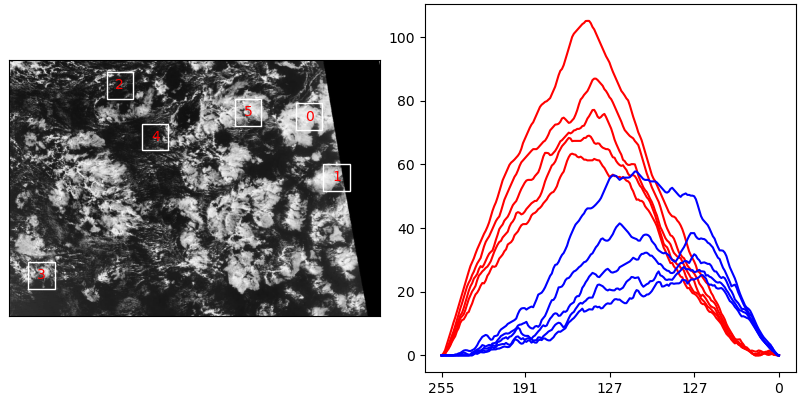

In [130]:
# Find a random index and pull the information for that 
rng = np.random.default_rng()
index = rng.integers(0, len(test_lscapes))
lscape = test_lscapes[index]
coords = test_boxes[index]
box = test_annos.iloc[index]
fn = IMGPATH + box.fn
# Print information about the sample we pulled, including the index if we want to revisit this example later
print(box.tool_label)
print(index)
print(prods[index])

# Set up the figure
F, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
# Plot the landscape
lscape_plotter(lscape, ax[1])

# Open and plot the base image
with Image.open(fn).convert('L') as img:
    ax[0].imshow(img.crop((box.x, box.y, box.x + box.width, box.y + box.height)), cmap='gray')

# Plot the subsample boxes
for i in range(len(coords)):
    rect = patches.Rectangle((coords[i][0] - box.x, coords[i][1] - box.y), sample_size, sample_size, facecolor='none', edgecolor='white', lw=1)
    ax[0].add_patch(rect)
    ax[0].get_xaxis().set_ticks([])
    ax[0].get_yaxis().set_ticks([])
    ax[0].text(coords[i][0] - box.x + sample_size/2, coords[i][1] - box.y + sample_size/2, i, ha='center', va='center', c='red')

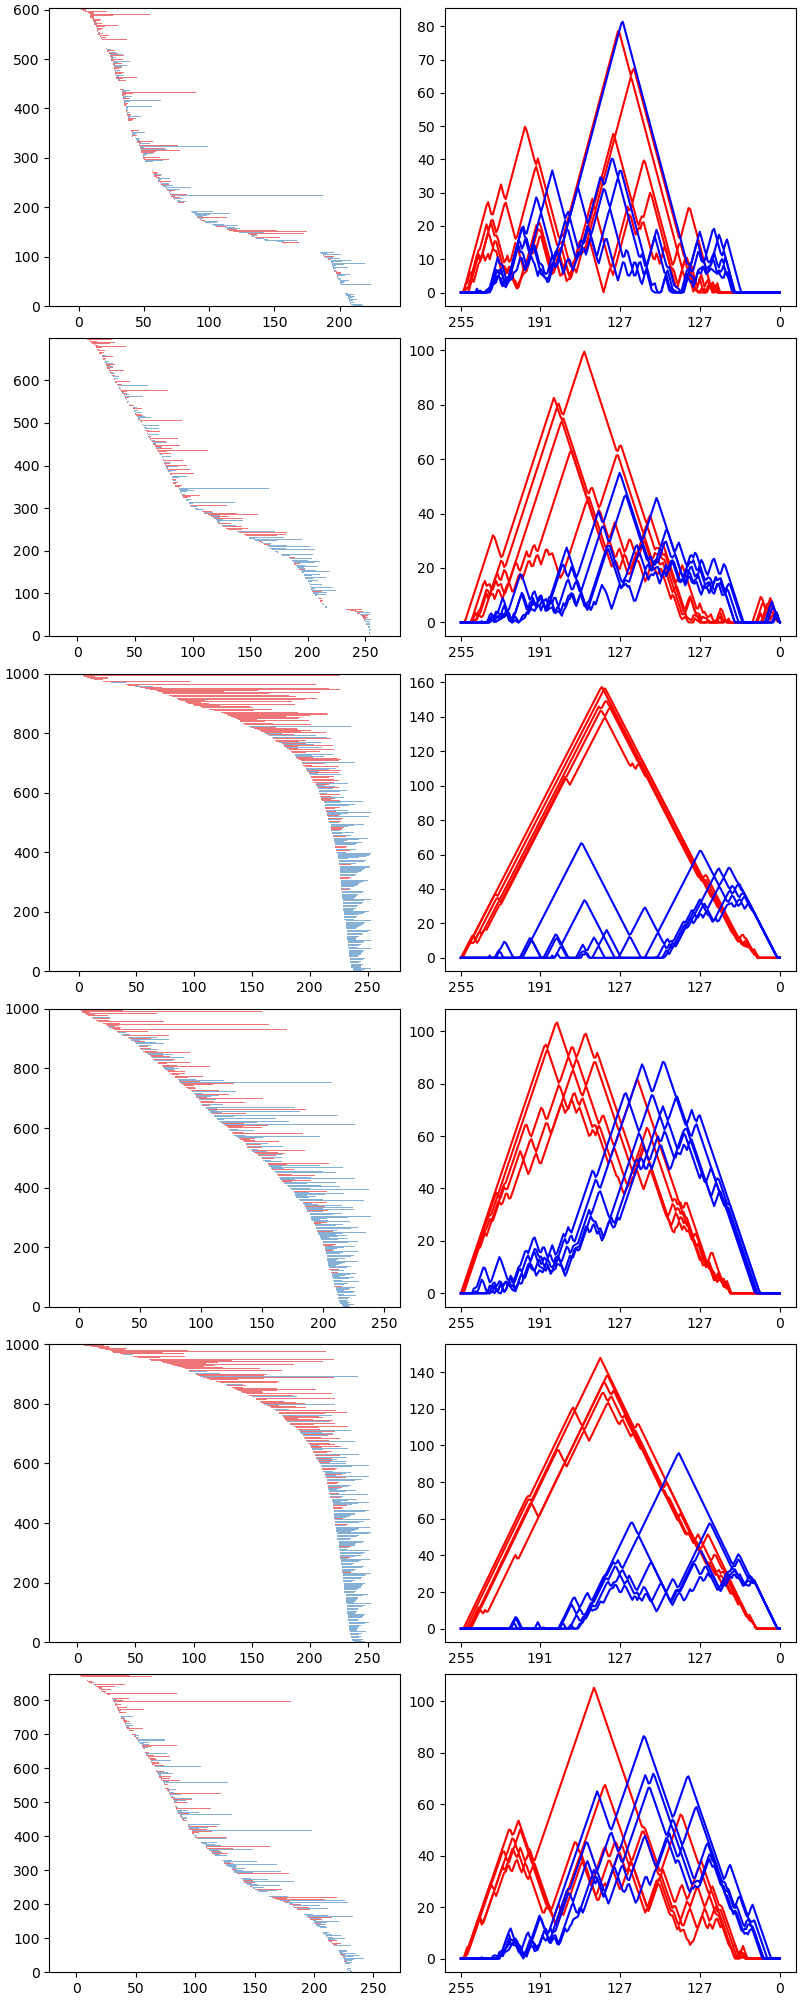

In [131]:
# Compute and plot the homology for the random sample pulled above

# Set up the plot
F, ax = plt.subplots(6, 2, figsize=(8, 20), constrained_layout=True)

# Open the image and convert it to grayscale
with Image.open(fn).convert('L') as img:
    # Loop over subsamples
    for i in range(len(coords)):
        # Pull the subsample as a numpy array and compute its sublevelset persistent homology
        img_sample = np.array(img.crop((coords[i][0], coords[i][1], coords[i][0] + sample_size, coords[i][1] + sample_size)))
        cmplx = gudhi.CubicalComplex(top_dimensional_cells=255-img_sample[:, :])
        bc = cmplx.persistence(homology_coeff_field=2)
        # Plot its persistence barcode
        gudhi.plot_persistence_barcode(bc, axes=ax[i, 0])
        ax[i, 0].set_xlabel('')
        ax[i, 0].set_ylabel('')
        ax[i, 0].set_title('')
        
        # Compute and plot its persistence landscape
        lscape_comp = gudhi.representations.Landscape(resolution=200, sample_range=(0, 255))
        sample_lscape = np.concatenate(lscape_comp.transform((cmplx.persistence_intervals_in_dimension(0), cmplx.persistence_intervals_in_dimension(1))))
        lscape_plotter(sample_lscape, ax[i, 1])